In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [3]:
samples['Sample Type'].value_counts()

Primary Tumor                                      8166
Solid Tissue Normal                                 636
Metastatic                                          385
Primary Blood Derived Cancer - Peripheral Blood     123
Recurrent Tumor                                      43
Additional - New Primary                             10
Additional Metastatic                                 1
Name: Sample Type, dtype: int64

In [4]:
samples.shape
cases = samples[samples['Sample Type']=='Primary Tumor'].sample(frac=1).copy()
cases.shape
proj = cases['project'].value_counts().head(10).index
cases = cases[cases['project'].isin(proj)]
cases['project'].value_counts()
cases.shape

(9364, 10)

(8166, 10)

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
BLCA     412
Name: project, dtype: int64

(5432, 10)

## Dataset Prep

In [5]:
from sklearn.model_selection import train_test_split

target = 'project'
cases[target] = cases[target].astype('category')
train, test = train_test_split(cases)

In [6]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np

if torch.cuda.is_available():
    cuda = torch.cuda.is_available()
    print("{} GPUs available".format(torch.cuda.device_count()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
classes = train[target].cat.categories.values


8 GPUs available


In [7]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)
print('Loaded')
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Loaded


## Siamese Network

In [8]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 64
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model = nn.DataParallel(model)
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 8
# print training metrics every log_interval * batch_size
log_interval = 4

DataParallel(
  (module): SiameseNet(
    (embedding_net): EmbeddingNet(
      (fc): Sequential(
        (0): Linear(in_features=60483, out_features=2000, bias=True)
        (1): PReLU(num_parameters=1)
        (2): Linear(in_features=2000, out_features=500, bias=True)
        (3): PReLU(num_parameters=1)
        (4): Linear(in_features=500, out_features=250, bias=True)
        (5): PReLU(num_parameters=1)
        (6): Linear(in_features=250, out_features=100, bias=True)
        (7): PReLU(num_parameters=1)
        (8): Linear(in_features=100, out_features=50, bias=True)
        (9): PReLU(num_parameters=1)
        (10): Linear(in_features=50, out_features=10, bias=True)
        (11): PReLU(num_parameters=1)
        (12): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
)

In [9]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/4074 (0%)]	Loss: 0.166327
Train: [256/4074 (6%)]	Loss: 4.554828
Train: [512/4074 (12%)]	Loss: 1.540081
Train: [768/4074 (19%)]	Loss: 1.832226
Train: [1024/4074 (25%)]	Loss: 3.391634
Train: [1280/4074 (31%)]	Loss: 2.000068
Train: [1536/4074 (38%)]	Loss: 1.571332
Train: [1792/4074 (44%)]	Loss: 0.536913
Train: [2048/4074 (50%)]	Loss: 0.968064
Train: [2304/4074 (56%)]	Loss: 0.328347
Train: [2560/4074 (62%)]	Loss: 0.313907
Train: [2816/4074 (69%)]	Loss: 1.735722
Train: [3072/4074 (75%)]	Loss: 0.797785
Train: [3328/4074 (81%)]	Loss: 0.506658
Train: [3584/4074 (88%)]	Loss: 0.271924
Train: [3840/4074 (94%)]	Loss: 0.202526
Epoch: 1/8. Train set: Average loss: 1.2983
Epoch: 1/8. Validation set: Average loss: 0.3018
Train: [0/4074 (0%)]	Loss: 0.143398
Train: [256/4074 (6%)]	Loss: 0.176637
Train: [512/4074 (12%)]	Loss: 0.111253
Train: [768/4074 (19%)]	Loss: 0.117425
Train: [1024/4074 (25%)]	Loss: 0.118959
Train: [1280/4074 (31%)]	Loss: 0.096325
Train: [1536/4074 (38%)]	Loss: 0.094081
Tra

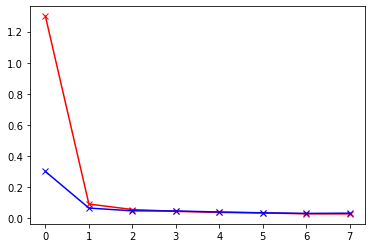

In [10]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

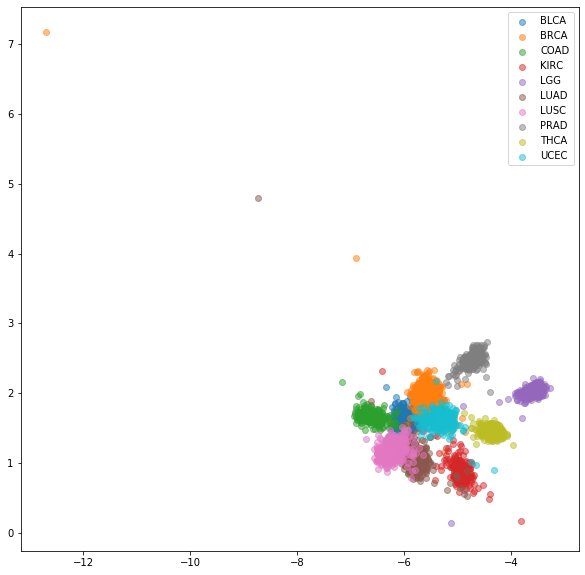

In [11]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

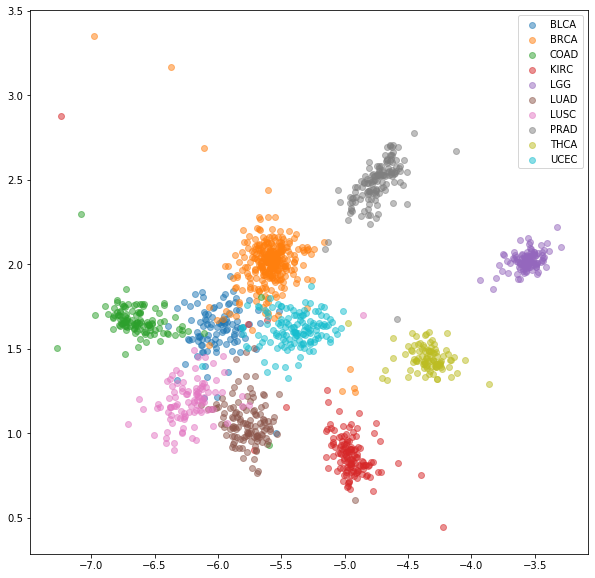

In [12]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)